# Ταξινόμηση εικόνας και αύξηση δεδομένων (Image classification and augmentation)

[Copyright 2018 The TensorFlow Authors.](https://www.tensorflow.org/tutorials/images/classification)

Στόχος αυτής της άσκησης είναι η δημιουργία ενός ταξινομητή εικόνων με χρήση του μοντέλου `tf.keras.Sequential` και του `preprocessing.image_dataset_from_directory` για την φόρτωση των δεδομένων. 

 Θα δείτε έννοιες μηχανικής μάθησης όπως: 
* Αποτελεσματική φόρτωση ενός συνόλου δεδομένων από το δίσκο. 
* Πώς να αναγνωρίσετε την υπερεκπαίδευση του μοντέλου και να την αποτρέψετε. 
* Βασικές τεχνικές αύξησης δεδομένων και dropout
 
 
 Η  βασική ροή εργασίας μηχανικής μάθησης, την οποία και θα ακολουθήσουμε είναι η εξής:

  1. Εξετάστε και κατανοήστε τα δεδομένα 
  2. Κατασκευάστε έναν pipeline εισόδου
  3. Κατασκευάστε το μοντέλο
  4. Εκπαιδεύστε το μοντέλο
  5. Δοκιμάστε το μοντέλο
  6. Βελτιώστε το μοντέλο και επαναλάβετε τη διαδικασία

## Εισαγωγή packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Εισαγωγή συνόλου δεδομένων

### Κατανόηση των δεδομένων

Θα χρησιμοποιήσουμε το σύνολο δεδομένων με σχεδόν 3700 φωτογραφίες λουλουδιών. Το σύνολο αυτό περιέχει 5 υποκατηγορίες, μία για κάθε κλάση:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


#### Ρύθμιση μεταβλητών για χρήση κατά την προεπεξεργασία του συνόλου δεδομένων και την εκπαίδευση του δικτύου.

Μετά τη λήψη, θα έχετε ένα αντίγραφο του συνόλου δεδομένων με 3670 συνολικές εικόνες:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Μερικές εικόνες από το σύνολο των δεδομένων:

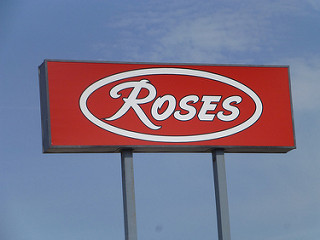

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

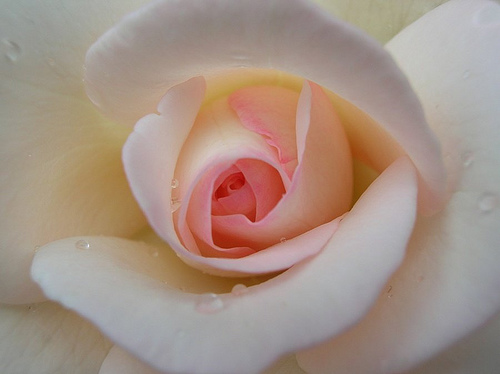

In [ ]:
PIL.Image.open(str(roses[1]))

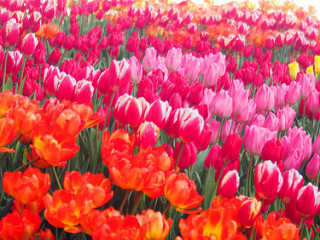

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

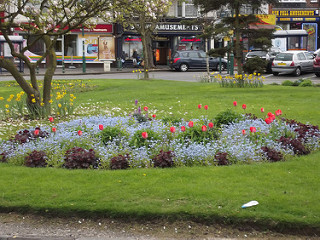

In [ ]:
PIL.Image.open(str(tulips[1]))

# Φόρτωση εικόνων με χρήση του keras.preprocessing

Θα φορτώσουμε αυτές τις εικόνες από το δίσκο χρησιμοποιώντας το βοηθητικό πρόγραμμα [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) το οποίο θα μετατρέψει σε ένα `tf.data.Dataset` τις εικόνες.

## Δημιουργία του συνόλου δεδομένων

Ορισμός παραμέτρων

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Δημιουργία συνόλου επικύρωσης (validation) χωρίζοντας το σύνολο εκπαίδευσης έτσι ώστε το 80% των εικόνων να χρησιμοποιηθεί για την εκπαίδευση και το 20% για τη επικύρωση.

![alt text](https://drive.google.com/uc?id=1KTSokAsQ66kVqiXZ9qkBXmU7srsWP1zW)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Μπορείτε να βρείτε τα ονόματα κλάσεων στο χαρακτηριστικό `class_names`

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Οπτικοποίηση των δεδομένων
Οι πρώτες 9 εικόνες από το σύνολο εκπαίδευσης.

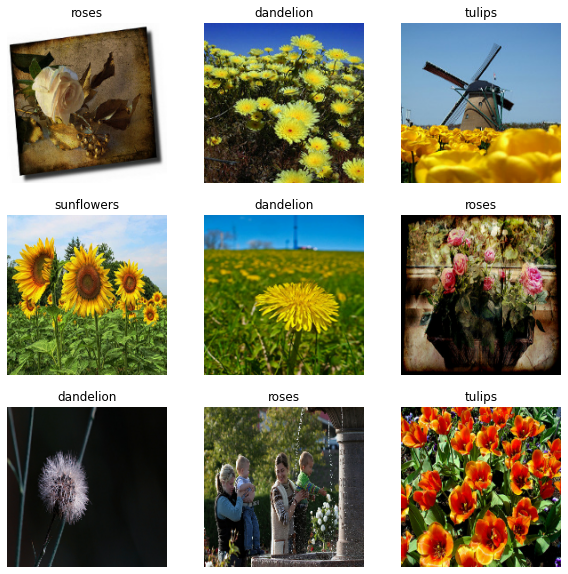

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Το `image_batch` είναι ένας τανυστής μεγέθους (32, 180, 180, 3). Πρόκειται για μια παρτίδα 32 εικόνων μεγέθους 180x180x3 (η τελευταία διάσταση αναφέρεται στα κανάλια χρώματος RGB). Η `label_batch` είναι ένας τανυστής του σχήματος (32,), που περιέχει τις αντίστοιχες ετικέτες για τις 32 εικόνες. 

Μπορείτε να καλέσετε ως `.numpy()` τους τανυστές `image_batch`και το `labels_batch` και να τους μετατρέψετε σε `numpy.ndarray`. 

## Διαμορφώστε το σύνολο δεδομένων για καλύτερη απόδοση

 Χρησιμοποιώντας το buffered prefetching και τις  ακόλουθες μεθόδους μπορείτε να χειριστείτε αποδοτικά  τα δεδομένα από το δίσκο:
 - Το `Dataset.cache()`  διατηρεί τις εικόνες στη μνήμη αφού φορτωθούν εκτός δίσκου κατά την πρώτη εποχή της εκπαίδευσης του δικτύου. Εάν το σύνολο δεδομένων σας είναι πολύ μεγάλο για να χωρέσει στη μνήμη, μπορείτε επίσης να χρησιμοποιήσετε αυτήν τη μέθοδο για να δημιουργήσετε μια προσωρινή κρυφή μνήμη στο δίσκο.
 - Το `Dataset.prefetch ()` πραγματοποιεί την προεπεξεργασία δεδομένων και την εκτέλεση μοντέλου κατά την εκπαίδευση

Περισσότερα στο  [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Ο 2ος τρόπος είναι πιο εύχρηστος διότι με αυτόν μπορείτε να συμπεριλάβετε το επίπεδο κανονικοποίησης εντός του ορισμού του μοντέλου σας.

## Κανονικοποίηση δεδομένων

Οι τιμές των RGB καναλιών κυμαίνονται μεταξύ `[0, 255]` και θα τις κανονικοποιήσουμε στο `[0, 1]`
Ακολουθούν 2 κελιά με διαφορετικό τρόπο κανονικοποίησης

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


*Σημείωση*: 

Το resized images πριν έγινε με τη χρήση της παραμέτρου `image_size` στην`image_dataset_from_directory`. 

Θα μπορούσαμε και αυτό να το ενσωματώσουμε στο μοντέλο μας, όπως κάναμε και με την κανονικοποίηση, χρησιμοποιώντας το [Resizing layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing).

# Δημιουργία μοντέλου
Το μοντέλο αποτελείται από ένα πλήρως συνδεδεμένο επίπεδο με 128 νευρώνων που ενεργοποιείται από μια συνάρτηση ενεργοποίησης `relu`.

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Μεταγλώττιση του μοντέλου
Επιλέγουμε το `optimizers.Adam` για optimizer και`losses.SparseCategoricalCrossentropy` για loss function. Για να δούμε την ακρίβεια κατά τη εκπαίδευση και την επικύρωσης για κάθε περίοδο εκπαίδευσης, χρησιμοποιούμε τη μεταβλητή `metrics`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Περίληψη μοντέλου

Βλέπουμε όλα τα επίπεδα του δικτύου με την μέθοδο `summary`:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 128)               12441728  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 12,442,373
Trainable params: 12,442,373
Non-trainable params: 0
_________________________________________________________________


## Εκπαίδευση του μοντέλου

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 9s 95ms/step - loss: 9.6679 - accuracy: 0.3065 - val_loss: 1.6296 - val_accuracy: 0.4087
Epoch 2/10
92/92 [==============================] - 7s 80ms/step - loss: 1.4986 - accuracy: 0.4302 - val_loss: 1.8506 - val_accuracy: 0.3420
Epoch 3/10
92/92 [==============================] - 7s 80ms/step - loss: 1.6811 - accuracy: 0.3937 - val_loss: 1.8961 - val_accuracy: 0.3311
Epoch 4/10
92/92 [==============================] - 7s 80ms/step - loss: 1.4910 - accuracy: 0.3307 - val_loss: 1.4932 - val_accuracy: 0.3529
Epoch 5/10
92/92 [==============================] - 7s 80ms/step - loss: 1.4198 - accuracy: 0.3668 - val_loss: 1.4295 - val_accuracy: 0.3283
Epoch 6/10
92/92 [==============================] - 7s 80ms/step - loss: 1.3855 - accuracy: 0.3604 - val_loss: 1.5300 - val_accuracy: 0.2616
Epoch 7/10
92/92 [==============================] - 7s 80ms/step - loss: 1.4511 - accuracy: 0.3144 - val_loss: 1.5310 - val_accuracy: 0.3665
Epoch 8/10
92

## Οπτικοποίηση αποτελεσμάτων εκπαίδευσης

Δημιουργία γραφημάτων του loss και accuracy για τα σύνολα εκπαίδευσης και επικύρωσης.

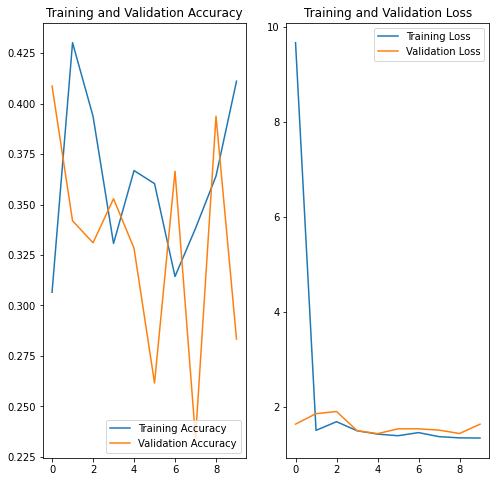

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Στα παραπάνω σχήματα, η ακρίβεια της εκπαίδευσης αυξάνεται γραμμικά με την πάροδο του χρόνου, ενώ η ακρίβεια επικύρωσης σταματά περίπου το 48% στη διαδικασία εκπαίδευσης. 

Επίσης, η διαφορά στην ακρίβεια μεταξύ εκπαίδευσης και ακρίβειας επικύρωσης είναι αισθητή - ένα σημάδι του [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). 

Όταν υπάρχει ένας μικρός αριθμός παραδειγμάτων εκπαίδευσης, το μοντέλο μερικές φορές μαθαίνει από θορύβους ή ανεπιθύμητες λεπτομέρειες από παραδείγματα του συνόλου εκπαίδευσης - σε βαθμό που επηρεάζει αρνητικά την απόδοση του μοντέλου σε νέα παραδείγματα. 
Αυτό το φαινόμενο είναι γνωστό ως overfitting. 

Αυτό σημαίνει ότι το μοντέλο θα έχει δυσκολία στη γενίκευση για ένα νέο σύνολο δεδομένων.
 Υπάρχουν πολλοί τρόποι για την καταπολέμηση της υπερεκπαίδευσης κατά τη διαδικασία εκπαίδευσης όπως η  *αύξηση δεδομένων* και το *Dropout*.

## Επαύξηση Δεδομένων (Data augmentation)

Η υπερεκπαίδευση συμβαίνει γενικά όταν υπάρχει μικρός αριθμός παραδειγμάτων εκπαίδευσης. 

Η *επαύξηση δεδομένων* ακολουθεί την προσέγγιση δημιουργίας πρόσθετων δεδομένων εκπαίδευσης από τα υπάρχοντα παραδείγματα, αυξάνοντάς τα χρησιμοποιώντας τυχαίους μετασχηματισμούς που αποδίδουν νέες εικόνες.

Αυτό βοηθά στην έκθεση του μοντέλου σε περισσότερες πτυχές των δεδομένων και γενικεύει καλύτερα. 

Θα εφαρμόσουμε επαύξηση δεδομένων χρησιμοποιώντας τα επίπεδα από το `tf.keras.layers.experimental.preprocessing`.

Αυτά μπορούν να συμπεριληφθούν στο μοντέλο σας, όπως και άλλα επίπεδα, και να εκτελούνται στην GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Ας δούμε κάποια παραδείγματα επαύξησης που εφαρμόζονται στη ίδια εικόνα πολλές φορές:

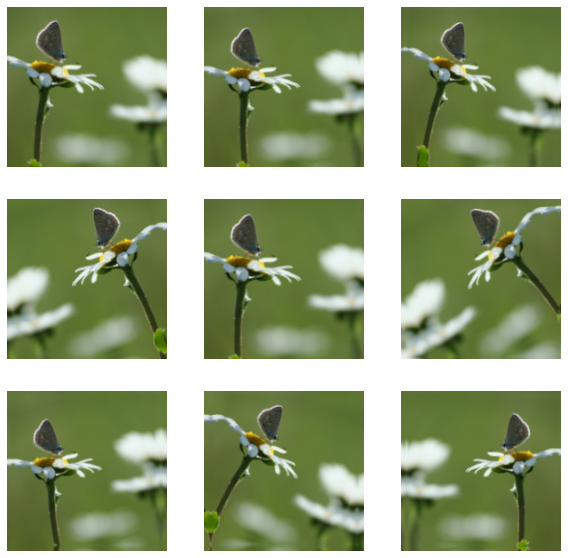

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Μια άλλη τεχνική για τη μείωση του overfitting είναι η εισαγωγή του [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) στο δίκτυο. Είναι μια μορφή κανονικοποίησης που αναγκάζει τα βάρη στο δίκτυο να λαμβάνουν μόνο μικρές τιμές, γεγονός που καθιστά την κατανομή των τιμών βάρους κανονική και το δίκτυο μπορεί να μειώσει την υπερεκπαίδευση σε μικρά δείγματα εκπαίδευσης.

Όταν εφαρμόσουμε το dropout σε ένα επίπεδο, "πετάμε" τυχαία (θέτοντας τα μηδέν) ένα πλήθος μονάδων εξόδου από το επίπεδο που το εφαρμόζουμε, κατά τη διάρκεια της διαδικασίας εκπαίδευσης. Το Dropout παίρνει έναν κλασματικό αριθμό ως την τιμή εισόδου του, με τη μορφή όπως 0,1, 0,2, 0,4, κ.λπ. Αυτό σημαίνει την κατάργηση 10%, 20% ή 40% των μονάδων εξόδου τυχαία από το εφαρμοζόμενο επίπεδο
<img src="https://drive.google.com/uc?id=1oFCbivJDng6naeUDQyGLpT_1ukYW5_YF" width=70%>

Ας δημιουργήσουμε ένα νέο νευρωνικό δίκτυο χρησιμοποιώντας το `layers.Dropout`, και στη συνέχεια θα το εκπαιδεύσουμε χρησιμοποιώντας επαύξηση δεδομένων.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

## Μεταγλώτιση και εκπαίδευση του μοντέλου

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 97200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               12441728  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 12,442,373
Trainable params: 12,442,373


In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 22s 232ms/step - loss: 7.5013 - accuracy: 0.2817 - val_loss: 1.5782 - val_accuracy: 0.3311
Epoch 2/15
92/92 [==============================] - 21s 232ms/step - loss: 1.5016 - accuracy: 0.3099 - val_loss: 1.5787 - val_accuracy: 0.3338
Epoch 3/15
92/92 [==============================] - 21s 231ms/step - loss: 1.5544 - accuracy: 0.2895 - val_loss: 1.5610 - val_accuracy: 0.2875
Epoch 4/15
92/92 [==============================] - 22s 236ms/step - loss: 1.5399 - accuracy: 0.3014 - val_loss: 1.6159 - val_accuracy: 0.2752
Epoch 5/15
92/92 [==============================] - 21s 231ms/step - loss: 1.5708 - accuracy: 0.2721 - val_loss: 1.5440 - val_accuracy: 0.2929
Epoch 6/15
92/92 [==============================] - 21s 232ms/step - loss: 1.5119 - accuracy: 0.3151 - val_loss: 1.5168 - val_accuracy: 0.3079
Epoch 7/15
92/92 [==============================] - 21s 231ms/step - loss: 1.5249 - accuracy: 0.3137 - val_loss: 1.5193 - val_accuracy: 0.3065

## Οπτικοποίηση αποτελεσμάτων εκπαίδευσης

Μετά τη εφαρμογή του data augmentation και του Dropout, υπάρχει μικρότερη υπερεκπαίδευση από ό, τι πριν, και η ακρίβεια της εκπαίδευσης και της επικύρωσης είναι πιο ευθυγραμμισμένες.

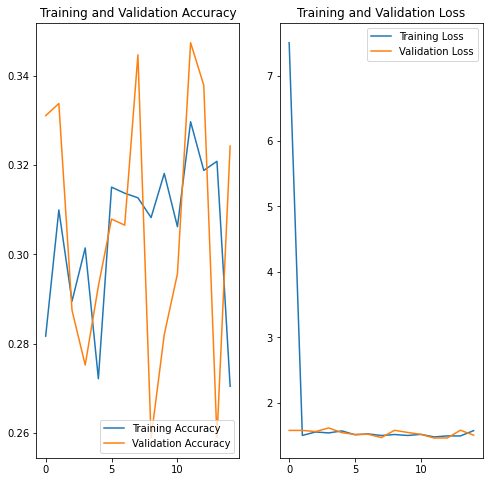

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Πρόβλεψη νέων δεδομένων

Τέλος, ας χρησιμοποιήσουμε το μοντέλο μας για να ταξινομήσουμε μια εικόνα που δεν περιλαμβάνεται στα σετ εκπαίδευσης ή επικύρωσης.

Σημείωση: Τα επίπεδα επαύξησης δεδομένων και dropout δεν είναι ενεργά κατά την εκτέλεση της πρόβλεψης.


In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to roses with a 48.04 percent confidence.


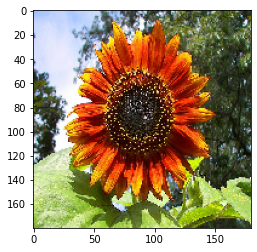

In [ ]:
plt.imshow(img)


Για περαιτέρω πρακτική εξάσκηση, δείτε το [tensorflow tutorials](https://www.tensorflow.org/tutorials)
